# MuchLearningSuchWow - LSTM - Crossvalidation

This notebook contains the code we used to run crossvalidation to find the best parameters for our network. The training code is based loosely on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7). The WRMSSE callback uses the same WRMSSE evaluator as the one used in `LSTM_Evaluation.ipynb`, which is based on [this discussion](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834). The Time Series Split used in this kernel was obtained from [this discussion](https://www.kaggle.com/mpearmain/extended-timeseriessplitter) from another Kaggle competition.

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle
import gc

from WRMSSEEvaluator import WRMSSEEvaluator
from TimeSeriesSplit import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
inputPath = "input/m5-forecasting-accuracy/"
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training
testSize = 28 # Number of days that will be used as the test set for every fold

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [5]:
df_train = df_train_valid[:-28] # Remove Kaggle validation data
del df_train_valid
gc.collect()
print(df_train.shape)

(913, 30504)


In [6]:
df_train_scaled = scaler.transform(df_train) # Scale the training data

### Create Training/Validation Data and Labels

In [7]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(df_train_scaled[i-timesteps:i])
    y_train.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

In [8]:
del df_train_scaled

In [9]:
# Convert data to np array to be able to feed it to the model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(899, 14, 30504)
(899, 30490)


### LSTM Model

In [10]:
def create_LSTM():
    model = Sequential()

    # 1D convolution layer
    model.add(Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", 
                     activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))

    # LSTM layers
    layer_1_units=150
    model.add(LSTM(units = layer_1_units, return_sequences = True))
    model.add(Dropout(0.3))

    layer_2_units=150
    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.3))

    layer_3_units=400
    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units = 30490))
    
    return model

In [11]:
model = create_LSTM()
plot_model(model, modelPath + "/model.png")
print(model.summary())
del model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            6832928   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 150)           109800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 150)           180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               881600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)              

### WRMSSE Evaluation Callback

In [12]:
class WRMSSECallback(Callback):
    
    def __init__( self, df_train_orginal, df_valid_original, df_calendar, df_prices, timesteps, 
                  input_data, scaler, nr_days_to_predict, additional_features, val_start_day):
        # Create evaluator and set all values necessary for testing & evaluation
        self.evaluator = WRMSSEEvaluator(df_train_orginal, df_valid_original, df_calendar, df_prices)
        self.timesteps = timesteps
        self.input_data = input_data
        self.scaler = scaler
        self.nr_days_to_predict = nr_days_to_predict
        self.additional_features = additional_features
        self.val_start_day = val_start_day
        
    def test_model( self, model ):
        # Note: this function is identical to the one in LSTM_Testing.ipynb
        
        # Scale and convert input data so that it can be fed into the model
        inputs = self.scaler.transform(self.input_data)
        X_test = np.array([inputs])
    
        # Predict sales for the next nr_days_to_predict days
        predictions = []
        for j in range(0, self.nr_days_to_predict):
            predicted_sales = model.predict(X_test[:,-self.timesteps:,:]
                                                 .reshape(1, self.timesteps, 30490 + additional_features.shape[1]))
            test_input = np.column_stack((np.array(predicted_sales), self.additional_features.iloc[[j]]))
            test_input_expanded = np.expand_dims(test_input, 0)
            X_test = np.append(X_test, test_input_expanded, axis = 1)
            predicted_sales = self.scaler.inverse_transform(test_input)[:,0:30490]
            predictions.append(predicted_sales)
    
        return predictions
    
    def evaluate( self, predictions ):
        # Reshape predictions in order to feed them to the evaluator
        predictions = pd.DataFrame(data=np.array(predictions).reshape(self.nr_days_to_predict,30490))
        predictions = predictions.T
        predictions.columns = [f"d_{i}" for i in range(self.val_start_day,self.val_start_day + self.nr_days_to_predict)]
        
        # Compute and return WRMSSE
        groups, scores = self.evaluator.score(predictions)
        wrmsse_score = np.mean(scores)
        
        return wrmsse_score
    
    def on_epoch_end( self, epoch, logs=None ):
        logs = logs or {}
        # Predict using the current state of the model, compute WRMSSE, add the result to the log and print it
        predictions = self.test_model(self.model)
        wrmsse_score = self.evaluate(predictions)
        logs['val_wrmsse'] = wrmsse_score
        print("Validation WRMSSE after epoch "+str(epoch+1)+": "+str(wrmsse_score))

In [13]:
# WRMSSE evaluator requires original, non-preprocessed data
df_sales = pd.read_csv(inputPath + "/sales_train_evaluation.csv")
df_calendar = pd.read_csv(inputPath + "/calendar.csv")
df_prices = pd.read_csv(inputPath + "/sell_prices.csv")
print(df_sales.iloc[:, :-28-28].shape)

(30490, 1891)


### Time Series Cross Validation

In [14]:
# Define the loss function (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
# Create time series splitter
nr_folds = 5
tss = TimeSeriesSplit(nr_folds, test_size=testSize)

In [16]:
# Set number of epochs per fold and batch size
nr_epochs = 25
batch_size = 32

In [17]:
# Cross Validation Loop
histories = []
for fold, (train_index, test_index) in enumerate(tss.split(X_train)):
    # Change fold from index to number and print the current fold
    fold += 1
    print("Fold "+str(fold)+"/"+str(nr_folds))
    
    # Split the data
    X_train_split, X_test_split = X_train[train_index], X_train[test_index]
    y_train_split, y_test_split = y_train[train_index], y_train[test_index]
    
    # Create a new model
    model = create_LSTM()
    
    # Compile the model
    model.compile(optimizer = Adam(learning_rate=0.001), loss = root_mean_squared_error)
    
    # Create WRMSSE evaluation callback
    val_start_day = startDay+len(train_index)+timesteps+1
    df_train_original = df_sales # df_sales.iloc[:, :val_start_day+5] only seems to work for the final fold...
    df_valid_original = df_sales.iloc[:, val_start_day+5:val_start_day+5+testSize]
    input_data = df_train[len(train_index):len(train_index)+timesteps]
    additional_features = df_train[len(train_index)+timesteps:len(train_index)+timesteps+testSize].iloc[:, 30490:]
    print("Creating WRMSSE callback...")
    wrmsse_valid = WRMSSECallback( df_train_original, df_valid_original, df_calendar, df_prices,
                                   timesteps, input_data, scaler, testSize, additional_features, val_start_day)
    
    # Create callbacks that save the models with the lowest validation loss and WRMSSE score
    mcp_save_loss = ModelCheckpoint(modelPath + "/lstm_model_best_loss_"+str(fold), 
                                    save_best_only=True, monitor='val_loss', mode='min')
    mcp_save_wrmsse = ModelCheckpoint(modelPath + "/lstm_model_best_wrmsse_"+str(fold), 
                                      save_best_only=True, monitor='val_wrmsse', mode='min')
        
    # Fit the model
    hist = model.fit(X_train_split, y_train_split, 
                     epochs = nr_epochs, 
                     validation_data = (X_test_split, y_test_split), 
                     batch_size = batch_size, 
                     verbose = 1,
                     callbacks = [wrmsse_valid, mcp_save_loss, mcp_save_wrmsse])
    
    # Save the final model
    model.save(modelPath + "/lstm_model_final_"+str(fold))
    
    # Store history and perform garbage collection
    histories.append(hist)
    del model
    del X_train_split
    del y_train_split
    del X_test_split
    del y_test_split
    del val_start_day
    del df_train_original
    del df_valid_original
    del input_data
    del additional_features
    del wrmsse_valid
    del mcp_save_loss
    del mcp_save_wrmsse
    gc.collect()
    print("\n")

Fold 1/5
Creating WRMSSE callback...



Train on 275 samples, validate on 28 samples
Epoch 1/25
275/275 [==============================] - 9s 31ms/step - loss: 0.1568 - val_loss: 0.1448
Validation WRMSSE after epoch 1: 1.5274189560963036
Epoch 2/25
275/275 [==============================] - 7s 26ms/step - loss: 0.1376 - val_loss: 0.1423
Validation WRMSSE after epoch 2: 1.0231195685187233
Epoch 3/25
275/275 [==============================] - 7s 26ms/step - loss: 0.1356 - val_loss: 0.1423
Validation WRMSSE after epoch 3: 1.091671933571398
Epoch 4/25
275/275 [==============================] - 7s 26ms/step - loss: 0.1351 - val_loss: 0.1419
Validation WRMSSE after epoch 4: 0.9876781487473835
Epoch 5/25
275/275 [==============================] - 7s 26ms/step - loss: 0.1348 - val_loss: 0.1417
Validation WRMSSE after epoch 5: 1.039015315175498
Epoch 6/25
275/275 [==============================] - 7s 26ms/step - loss: 0.1348 - val_loss: 0.1420
Validation WRMSSE after epoch 6: 0.9253091550310466
Epoch 7/25
275/275 [==================


Train on 424 samples, validate on 28 samples
Epoch 1/25
424/424 [==============================] - 12s 28ms/step - loss: 0.1519 - val_loss: 0.1446
Validation WRMSSE after epoch 1: 1.1383862275976846
Epoch 2/25
424/424 [==============================] - 11s 26ms/step - loss: 0.1387 - val_loss: 0.1411
Validation WRMSSE after epoch 2: 1.16597621647039
Epoch 3/25
424/424 [==============================] - 11s 26ms/step - loss: 0.1371 - val_loss: 0.1404
Validation WRMSSE after epoch 3: 1.0659587619975845
Epoch 4/25
424/424 [==============================] - 11s 26ms/step - loss: 0.1364 - val_loss: 0.1393
Validation WRMSSE after epoch 4: 1.0675272564761868
Epoch 5/25
424/424 [==============================] - 11s 26ms/step - loss: 0.1351 - val_loss: 0.1388
Validation WRMSSE after epoch 5: 1.0796254768250262
Epoch 6/25
424/424 [==============================] - 11s 26ms/step - loss: 0.1342 - val_loss: 0.1385
Validation WRMSSE after epoch 6: 1.0673741914081798
Epoch 7/25
424/424 [============


Train on 573 samples, validate on 28 samples
Epoch 1/25
573/573 [==============================] - 15s 26ms/step - loss: 0.1503 - val_loss: 0.1492
Validation WRMSSE after epoch 1: 1.2185908342394216
Epoch 2/25
573/573 [==============================] - 14s 25ms/step - loss: 0.1393 - val_loss: 0.1483
Validation WRMSSE after epoch 2: 0.9928016107883018
Epoch 3/25
573/573 [==============================] - 14s 25ms/step - loss: 0.1388 - val_loss: 0.1483
Validation WRMSSE after epoch 3: 1.2462490005558504
Epoch 4/25
573/573 [==============================] - 14s 25ms/step - loss: 0.1383 - val_loss: 0.1473
Validation WRMSSE after epoch 4: 0.9962886813865041
Epoch 5/25
573/573 [==============================] - 14s 25ms/step - loss: 0.1369 - val_loss: 0.1467
Validation WRMSSE after epoch 5: 1.0329959704764196
Epoch 6/25
573/573 [==============================] - 14s 24ms/step - loss: 0.1367 - val_loss: 0.1460
Validation WRMSSE after epoch 6: 0.9464738336319135
Epoch 7/25
573/573 [==========


Train on 722 samples, validate on 28 samples
Epoch 1/25
722/722 [==============================] - 19s 27ms/step - loss: 0.1520 - val_loss: 0.1517
Validation WRMSSE after epoch 1: 1.4266029963673779
Epoch 2/25
722/722 [==============================] - 18s 26ms/step - loss: 0.1419 - val_loss: 0.1501
Validation WRMSSE after epoch 2: 1.2162128042914915
Epoch 3/25
722/722 [==============================] - 18s 26ms/step - loss: 0.1402 - val_loss: 0.1477
Validation WRMSSE after epoch 3: 1.126167529983953
Epoch 4/25
722/722 [==============================] - 20s 27ms/step - loss: 0.1389 - val_loss: 0.1475
Validation WRMSSE after epoch 4: 1.0916214742400314
Epoch 5/25
722/722 [==============================] - 19s 26ms/step - loss: 0.1379 - val_loss: 0.1475
Validation WRMSSE after epoch 5: 1.1126069802613714
Epoch 6/25
722/722 [==============================] - 19s 26ms/step - loss: 0.1375 - val_loss: 0.1475
Validation WRMSSE after epoch 6: 1.1758783887442206
Epoch 7/25
722/722 [===========


Train on 871 samples, validate on 28 samples
Epoch 1/25
871/871 [==============================] - 22s 26ms/step - loss: 0.1521 - val_loss: 0.1596
Validation WRMSSE after epoch 1: 1.3723751252822225
Epoch 2/25
871/871 [==============================] - 22s 25ms/step - loss: 0.1433 - val_loss: 0.1572
Validation WRMSSE after epoch 2: 1.3075461561809878
Epoch 3/25
871/871 [==============================] - 21s 25ms/step - loss: 0.1414 - val_loss: 0.1577
Validation WRMSSE after epoch 3: 1.4580251425184614
Epoch 4/25
871/871 [==============================] - 21s 25ms/step - loss: 0.1406 - val_loss: 0.1558
Validation WRMSSE after epoch 4: 1.0854939325892805
Epoch 5/25
871/871 [==============================] - 22s 25ms/step - loss: 0.1394 - val_loss: 0.1555
Validation WRMSSE after epoch 5: 1.132233387136064
Epoch 6/25
871/871 [==============================] - 22s 25ms/step - loss: 0.1383 - val_loss: 0.1550
Validation WRMSSE after epoch 6: 0.9225330077137405
Epoch 7/25
871/871 [===========

### Plotting Losses

In [18]:
def plot_loss(train_losses, val_losses, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(1, nr_epochs+1), np.mean(train_losses, axis = 0), label='train_loss')
    plt.plot(np.arange(1, nr_epochs+1), np.mean(val_losses, axis = 0), label='val_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_wrmsse(val_wrmsses, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(1, nr_epochs+1), np.mean(val_wrmsses, axis = 0), label='val_wrmsse')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('WRMSSE')
    plt.legend(loc='upper right')
    plt.show()

In [19]:
train_losses = []
val_losses = []
val_wrmsses = []
for fold in histories:
    train_losses.append(fold.history['loss'])
    val_losses.append(fold.history['val_loss'])
    val_wrmsses.append(fold.history['val_wrmsse'])

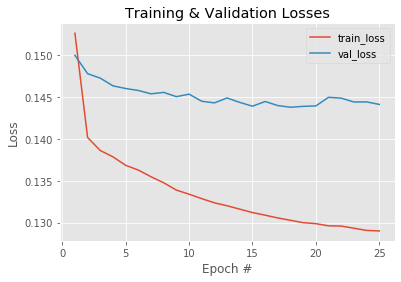

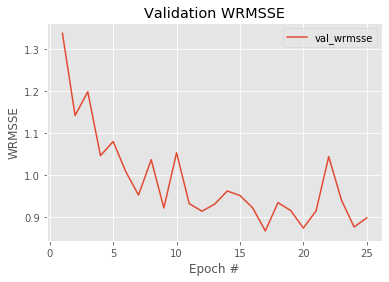

In [20]:
plot_loss(train_losses, val_losses, nr_epochs, 'Training & Validation Losses')
plot_wrmsse(val_wrmsses, nr_epochs, 'Validation WRMSSE')